In [7]:
import numpy as np
import osmnx as ox
import networkx as nx
from sklearn.neighbors import KDTree
from shapely.geometry import box
from shapely.geometry import shape
import shapefile
from pyproj import Proj, transform
import folium
from folium import plugins
import matplotlib.pyplot as plt
from matplotlib import rcParams
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO
import pandas as pd
import geopandas as gpd
import io
import pysal as ps

%matplotlib inline

rcParams['font.size'] = 14
rcParams['lines.linewidth'] = 2
rcParams['figure.figsize'] = (10, 10)

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
    'width': '100%',
    'height': '100%',
    'scroll': True,
    'font-size': '12px'
})

{'font-size': '12px', 'height': '100%', 'scroll': True, 'width': '100%'}

# Roadkill data visualization in Jupyter Notebook
## Huang-Sin Syu
PH.D. Student, Department of Geomatics, NCKU

## Abstract
This set of slides is an introduction to geospatial data visualization with roadkill data. It will show how to construct geospatial objects from tabular vector data or shapefiles. To work with these geospatial data in Python, we can use GeoPandas, shapely or related libraries for manipulating and analyzing the data. This slideset will also cover the following parts: loading data from CSV and shapefile, visualizing geospatial data with matplotlib and folium, using spatial operations to make thematic maps, fetching the street newtorks from OpenStreetMap, as well as visualizing them with the osmnx package. All of our datasets come from the research data repository [data.depositar.io](https://data.depositar.io/) except street networks data. The techniques presented here can be used for advanced spatial analysis and for exploring spatial relation in various application scenarios.

# 1. Loading a sample roadkill dataset
The Pandas library already has a built-in function read_csv( ) for retrieving data from a public link. We can use it to download the roadkill dataset and view the first 5 items.

In [2]:
rk_species = pd.read_csv('https://data.depositar.io/dataset/b78e1f21-1f5d-4fb6-95b5-619f3cb44797/resource/0158ed0f-1989-4a64-b67c-e7962c353d57/download/export-example.csv')
rk_species.head()

,id,科名,科名（中文）,物種名,物種名（中文）,紀錄時間,地點,經度,緯度
0,24933,Bufonidae,蟾蜍科,Rana longicrus,長腳赤蛙,2016-01-01,宜蘭縣員山鄉,121.636558,24.754443
1,24934,Muscicapidae,鶲科,Turdus pallidus,白腹鶇,2016-01-02,基隆市中正區,122.081660,25.628610
2,24935,Muridae,鼠科,Bandicota indica,鬼鼠,2016-01-02,高雄市茄萣區,120.195258,22.894975
3,24944,Talpidae,鼴鼠科,Mogera insularis insularis,台灣鼴鼠,2016-01-03,台中市北屯區,120.788463,24.173821
4,24971,Colubridae,黃頷蛇科,Lycodon ruhstrati ruhstrati,白梅花蛇,2016-01-04,新竹縣峨眉鄉,120.984170,24.698021


## Converting an existing DataFrame into an GeoDataFrame

In [3]:
rk_species['紀錄時間'] = pd.to_datetime(rk_species['紀錄時間'])
rk_geo = [gpd.geoseries.Point(loc) for loc in zip(rk_species['經度'], rk_species['緯度'])]
rk_species = gpd.GeoDataFrame(rk_species, geometry=rk_geo, crs={'init': 'epsg:4326'})
rk_species.geometry.head()

0    POINT (121.636558 24.754443)
1      POINT (122.08166 25.62861)
2    POINT (120.195258 22.894975)
3    POINT (120.788463 24.173821)
4     POINT (120.98417 24.698021)
Name: geometry, dtype: object

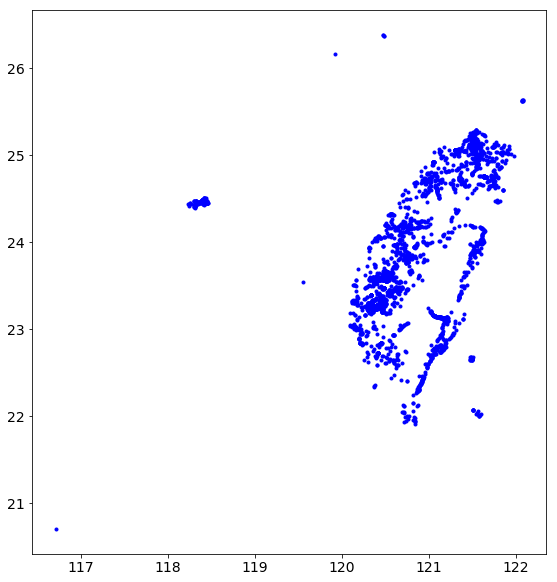

In [42]:
rk_species.plot(marker='.', color='b')

## Using the Folium library to visualize our roadkill dataset
Each observation can be represented as a point on the map. It need to be converted to an appropriate format for the HeatMap plugins in Folium.

In [43]:
osmMap = folium.Map(location=[23.5, 121], zoom_start=7)
osmMap.add_child(plugins.HeatMap([(geo.y, geo.x) for geo in rk_species.geometry], 
                                radius=15, blur=12))

## Spliting the dataset into specific group depending on the columns we choose
Using the groupby function to split data depending on the scientific names of species and aggregating these data to find out which one is the most observed in our dataset. 

In [46]:
rk_species.groupby(['物種名', '物種名（中文）']).size().sort_values(ascending=False).head()

物種名                         物種名（中文）
Duttaphrynus melanostictus  黑眶蟾蜍       274
Cyclophiops major           青蛇         143
Passer montanus saturatus   麻雀         140
Japalura swinhonis          斯文豪氏攀蜥     123
Bufo bankorensis            盤古蟾蜍       117
dtype: int64

In [48]:
target = rk_species[rk_species['物種名'] == 'Duttaphrynus melanostictus']
targetMap = folium.Map(location=[24, 121], zoom_start=7)
targetMap.add_child(plugins.HeatMap([(geo.y, geo.x) for geo in target.geometry], 
                                radius=15, blur=12))

## Checking out the number of observations by months
In this part, the column of record time is set to be the index of DataFrame. It help us extract timeseries data from our dataset for different date ranges.  

In [12]:
rk_species.index = rk_species['紀錄時間']
rk_species.head()

,id,科名,科名（中文）,物種名,物種名（中文）,紀錄時間,地點,經度,緯度,geometry
紀錄時間,,,,,,,,,,
2016-01-01,24933,Bufonidae,蟾蜍科,Rana longicrus,長腳赤蛙,2016-01-01,宜蘭縣員山鄉,121.636558,24.754443,POINT (121.636558 24.754443)
2016-01-02,24934,Muscicapidae,鶲科,Turdus pallidus,白腹鶇,2016-01-02,基隆市中正區,122.081660,25.628610,POINT (122.08166 25.62861)
2016-01-02,24935,Muridae,鼠科,Bandicota indica,鬼鼠,2016-01-02,高雄市茄萣區,120.195258,22.894975,POINT (120.195258 22.894975)
2016-01-03,24944,Talpidae,鼴鼠科,Mogera insularis insularis,台灣鼴鼠,2016-01-03,台中市北屯區,120.788463,24.173821,POINT (120.788463 24.173821)
2016-01-04,24971,Colubridae,黃頷蛇科,Lycodon ruhstrati ruhstrati,白梅花蛇,2016-01-04,新竹縣峨眉鄉,120.984170,24.698021,POINT (120.98417 24.698021)


In [51]:
timeseries_data = rk_species.resample('M').size()
timeseries_data

index_left
2016-01-31     271
2016-02-29     296
2016-03-31     283
2016-04-30    1028
2016-05-31     755
2016-06-30     561
2016-07-31      23
2016-08-31       1
Freq: M, dtype: int64

Text(0,0.5,'Frequency')

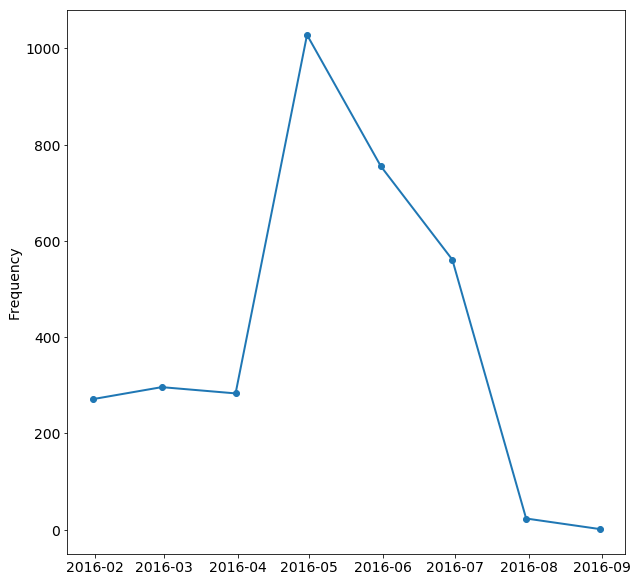

In [52]:
fig, ax = plt.subplots()
ax.plot_date(timeseries_data.index, timeseries_data, linestyle='-')
ax.set_ylabel('Frequency')

# 2. Loading the Tainan City (台南市) shapefile


In [15]:
link = 'https://data.depositar.io/dataset/796293f0-bee5-4810-918b-5a7df49d958b/resource/be3942ce-b098-49e2-8d54-07258c48b78b/download/2_tainan_3.zip'

def loadshp(link):
    zipfile = ZipFile(BytesIO(urlopen(link).read()))
    ext = [x for x in zipfile.namelist() if x.endswith(('shp', 'dbf', 'shx', 'prj')) and not x.startswith('__')]
    filename = {e.split('.')[1]:e for e in ext}
    return [BytesIO(zipfile.read(v)) for k, v in filename.items()]

dbf, prj, shp, shx = loadshp(link)
county = shapefile.Reader(shp=shp, shx=shx, dbf=dbf)

In [21]:
county.numRecords

39

In [16]:
attributes, geometry = [], []
field_names = [cln[0] for cln in county.fields[1:]]

for r in county.shapeRecords():
    geometry.append(shape(r.shape.__geo_interface__))
    r.record = map(lambda x: x.decode('big5') if isinstance(x, bytes) else x, r.record)
    attributes.append(dict(zip(field_names, r.record)))

In [53]:
attributes[1]

{'countyname': '臺南市',
 'towncode': '6700034',
 'townid': '67000033',
 'townname': '北區'}

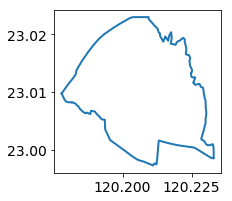

In [54]:
x, y = geometry[1].exterior.xy
plt.figure(figsize=(3,3))
plt.plot(x, y)

In [19]:
gdf = gpd.GeoDataFrame(data=attributes, geometry=geometry, crs={'init': 'epsg:4326'})
gdf.head()

,countyname,towncode,townid,townname,geometry
0,臺南市,6700035,67000032,安南區,"POLYGON ((120.1727360776201 23.08364539706148,..."
1,臺南市,6700034,67000033,北區,"POLYGON ((120.1779402208271 23.00974395810449,..."
2,臺南市,6700031,67000026,永康區,"POLYGON ((120.246957768584 23.06559782164893, ..."
3,臺南市,6700026,67000027,左鎮區,"POLYGON ((120.3583924728384 23.07156791345639,..."
4,臺南市,6700030,67000028,龍崎區,"POLYGON ((120.3530090989097 23.00036455925004,..."


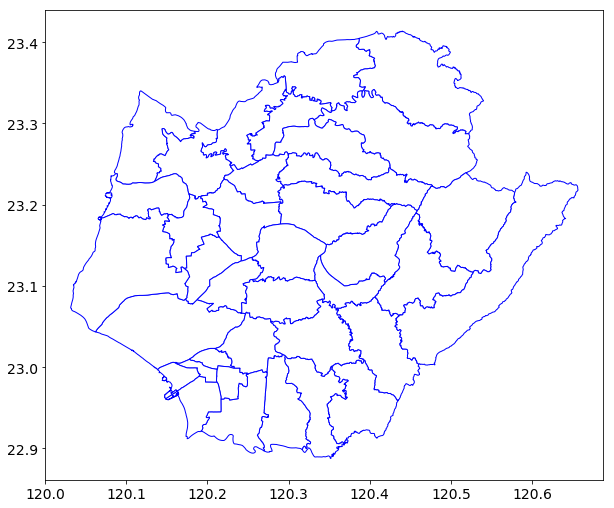

In [20]:
gdf.plot(color='w', edgecolor='b')

Creating a GeoPandas DataFrame from the list of geometry, attributes and setting the CRS associated with the geometry column in GeoPandas object. This make us can be enabled the spatial operation on these objects.

## Coordinate reference system (CRS)
CRS refers to Coordinate Reference System. You can find the epsg codes for various projections from [epsg.io](http://epsg.io/) . If your geospatial objects come from different resources with differernt CRS, you need to convert to the same CRS before you apply spaital operators to them.

In [22]:
gdf.head(2)

,countyname,towncode,townid,townname,geometry
0,臺南市,6700035,67000032,安南區,"POLYGON ((120.1727360776201 23.08364539706148,..."
1,臺南市,6700034,67000033,北區,"POLYGON ((120.1779402208271 23.00974395810449,..."


In [23]:
gdf.to_crs(epsg=3826).head(2)

,countyname,towncode,townid,townname,geometry
0,臺南市,6700035,67000032,安南區,"POLYGON ((165245.5765290013 2553785.381085007,..."
1,臺南市,6700034,67000033,北區,"POLYGON ((165732.8032140007 2545598.412270008,..."


# 3. Spatial Join by Geographic Region or Attributes

In [24]:
count = gpd.sjoin(rk_species, gdf, op='within').groupby(['townname']).size().to_frame()
count.columns = ['count']
count = count.reset_index()
count.head()

,townname,count
0,七股區,4
1,下營區,5
2,中西區,4
3,仁德區,9
4,六甲區,81


In [25]:
gdf = gdf.merge(count, on='townname', how='left')
gdf = gdf.fillna(0)
gdf.head()

,countyname,towncode,townid,townname,geometry,count
0,臺南市,6700035,67000032,安南區,"POLYGON ((120.1727360776201 23.08364539706148,...",18.0
1,臺南市,6700034,67000033,北區,"POLYGON ((120.1779402208271 23.00974395810449,...",2.0
2,臺南市,6700031,67000026,永康區,"POLYGON ((120.246957768584 23.06559782164893, ...",0.0
3,臺南市,6700026,67000027,左鎮區,"POLYGON ((120.3583924728384 23.07156791345639,...",0.0
4,臺南市,6700030,67000028,龍崎區,"POLYGON ((120.3530090989097 23.00036455925004,...",1.0


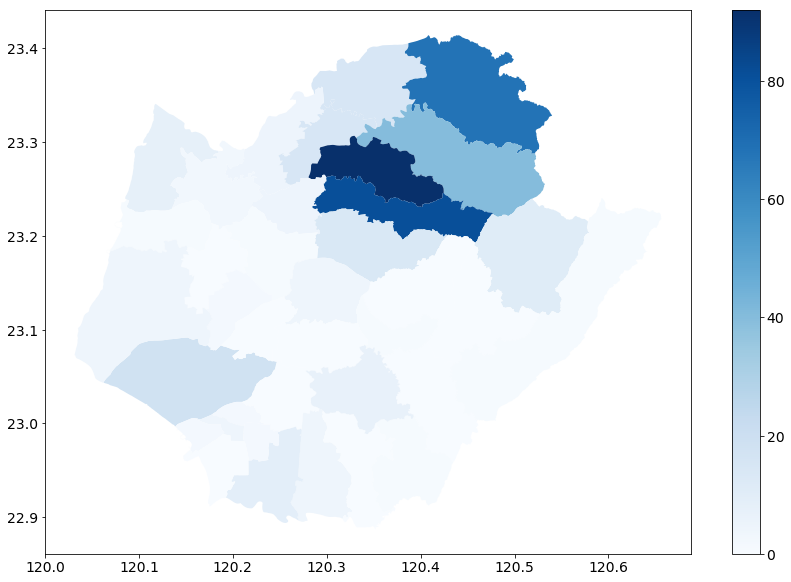

In [26]:
gdf.plot(column='count', figsize=(15, 10), cmap=plt.cm.Blues, legend=True)

# 4. Fetch OSM Networks from Points in Tainan

OpenStreetMap (OSM) is a successful Volunteered Geographic Information (VGI) system. The data provided by the OSM is crowdsourced, completely free to use, can be redistributed to anyone for any purpose. So it's very helpful to create custom maps in Jupyter Notebooks.

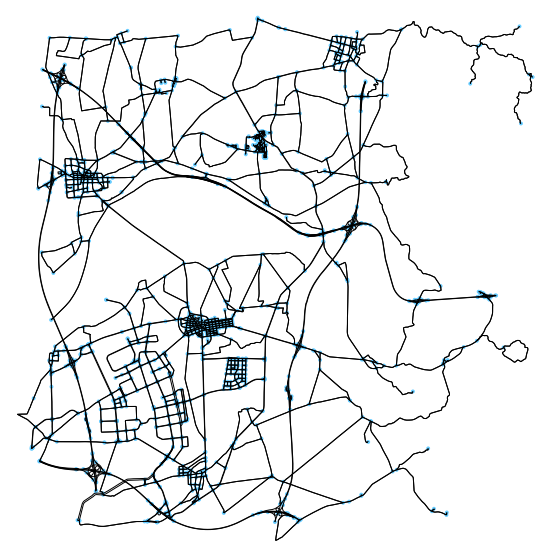

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11f6ea4e0>)

In [27]:
city = ox.graph_from_point((gdf.unary_union.centroid.y, gdf.unary_union.centroid.x),
                           distance=10000,
                           network_type='drive')
ox.plot_graph(city, fig_height=10, fig_width=10, edge_color='black')

In [28]:
nodes_prj, edges_prj = ox.graph_to_gdfs(city, nodes=True, edges=True)
boundary = box(*edges_prj.unary_union.bounds)
print(boundary)

POLYGON ((120.4223099 23.0542733, 120.4223099 23.2407475, 120.2224317 23.2407475, 120.2224317 23.0542733, 120.4223099 23.0542733))


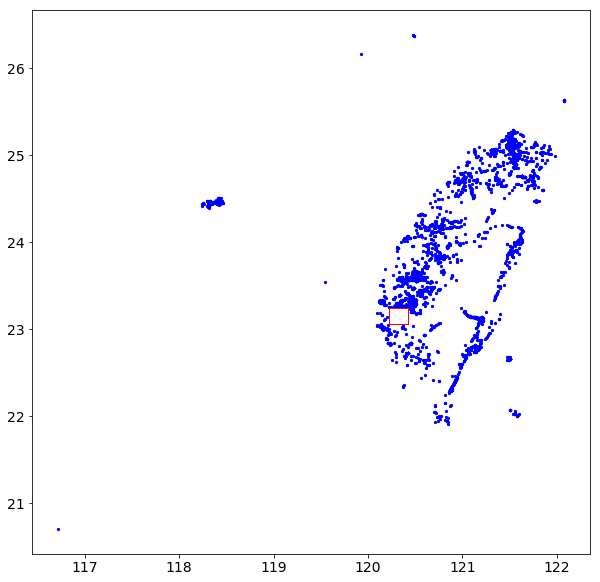

In [55]:
fig, ax = plt.subplots()
boundarySelection = gpd.GeoDataFrame(geometry=[boundary], crs=rk_species.crs)
rk_species.plot(ax=ax, markersize=5, color='b')
boundarySelection.plot(ax=ax, color='white', edgecolor='r')

In [30]:
rk_species_filter = gpd.sjoin(rk_species, boundarySelection, op='within')

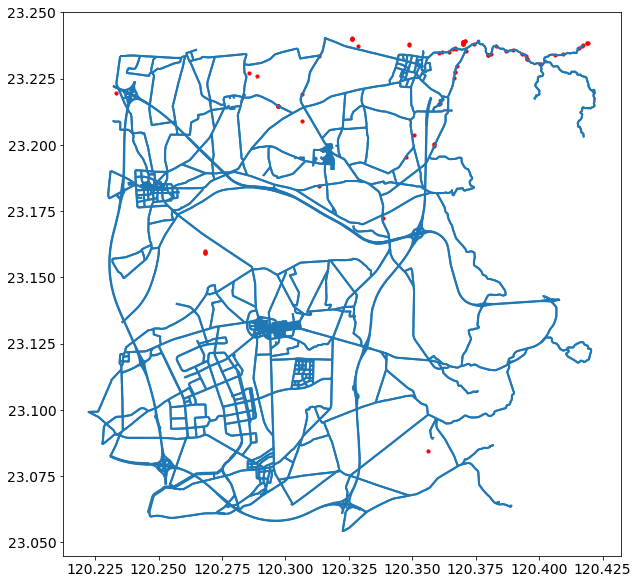

In [31]:
fig, ax = plt.subplots()
edges_prj.plot(ax=ax)
rk_species_filter.plot(ax=ax, markersize=10, color='red')

In [32]:
print(edges_prj.geometry[0])

LINESTRING (120.2615605 23.2026848, 120.2619655 23.2022596, 120.2631373 23.201085, 120.2646991 23.1996132)


In [56]:
partcity = ox.graph_from_point((23.225, 120.375), distance=5000, network_type='drive')
partmap = ox.plot_graph_folium(partcity)
partmap

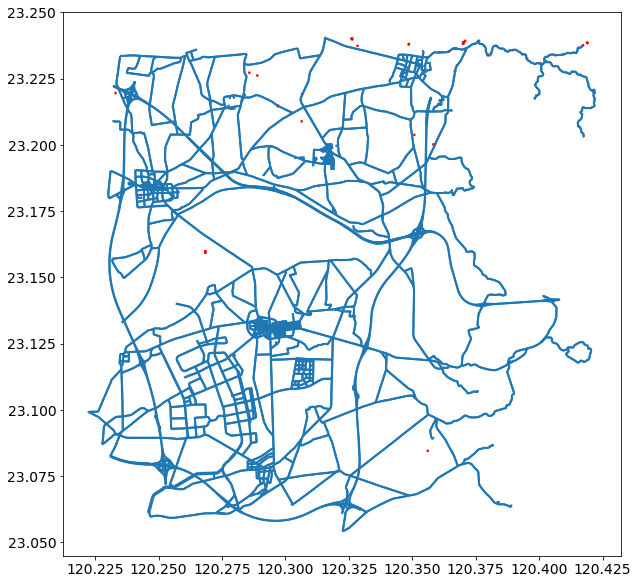

In [59]:
fig, ax = plt.subplots()
edges_prj.plot(ax=ax)
rk_species_filter.buffer(0.0005).plot(ax=ax, color='r') # 50m

In [35]:
rk_species_filter_buf = rk_species_filter.buffer(0.0005)

In [36]:
edges_prj['rkcount'] = 0
addList = []
for p in rk_species_filter_buf:
    for r in edges_prj[edges_prj.intersects(p)].iterrows():
        addList.append(r[0])

In [37]:
counts = pd.DataFrame(addList)[0].value_counts()
for i in range(len(counts.index)):
    edges_prj.at[counts.index[i], 'rkcount'] = counts[counts.index[i]]

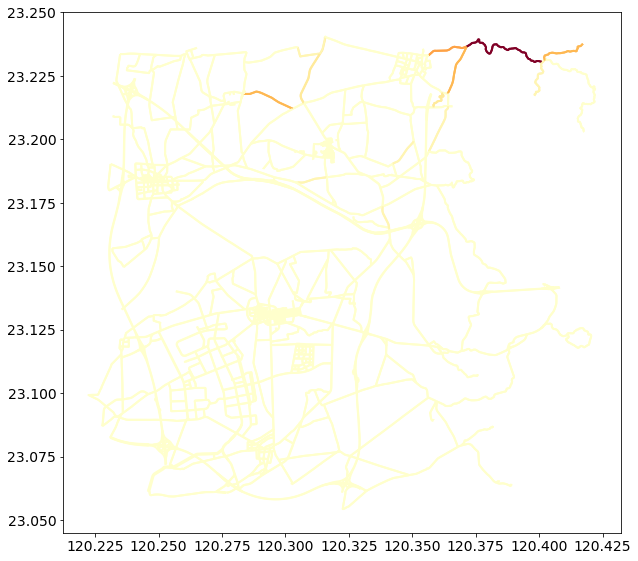

In [38]:
edges_prj.plot(column='rkcount', cmap='YlOrRd')

In [39]:
edges_prj[edges_prj['rkcount']>10]

,access,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,rkcount
992,NaN,NaN,"LINESTRING (120.3714228 23.236578, 120.3719208...",secondary,NaN,0,NaN,4250.401,NaN,曾文街,False,"[490132307, 362399125, 362399127]",174,NaN,NaN,3074364434,2274875711,14
2389,NaN,NaN,"LINESTRING (120.40101 23.2304863, 120.4009222 ...",secondary,NaN,0,NaN,4250.401,NaN,曾文街,False,"[490132307, 362399125, 362399127]",174,NaN,NaN,2274875711,3074364434,14


# Thank you
## try to load data from open data platform into your Jupyter Notebook :)